<a href="https://colab.research.google.com/github/jan-zika/computer_vision/blob/main/image_manipulation_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
from datetime import datetime

import ipywidgets as widgets
from IPython.display import display

In [ ]:
# The safe widget helper funcitons for Github previews
from IPython.display import display, Markdown

def where_am_i():
    """Detect if running in Colab, Jupyter, or other."""
    import sys
    try:
        import google.colab
        return "colab"
    except ImportError:
        if "ipykernel" in sys.modules:
            return "jupyter"
    return "other"

def safe_widget(widget_func, static_preview_func=None, message="**[Interactive widget – run in Colab to use it!]**"):
    """
    Display a widget if interactive environment, otherwise show static fallback.

    Parameters
    ----------
    widget_func : callable
        Function that builds and returns widget(s).
    static_preview_func : callable, optional
        Function that generates and displays a static preview (e.g., matplotlib plot).
    message : str
        Markdown fallback if no static preview is provided.
    """
    env = where_am_i()
    if env in ("colab", "jupyter"):
        return widget_func()
    else:
        if static_preview_func:
            static_preview_func()
        else:
            display(Markdown(message))

In [ ]:
# Base URL for all images
images_base_url = "https://raw.githubusercontent.com/jan-zika/computer_vision/refs/heads/main/images/"

#Image manipulation

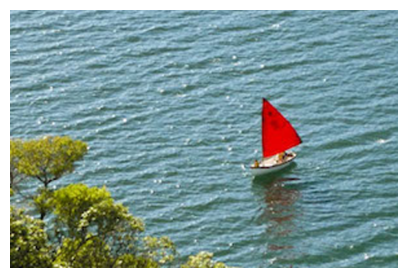

In [ ]:
# Image filename
image_name_01 = "New_Zealand_Boat.jpg"

# Construct full URL
image_url_01 = images_base_url + image_name_01

# Use urlopen to get the image data and cv2.imdecode to read it
try:
    resp = urlopen(image_url_01)
    image_array = np.asarray(bytearray(resp.read()), dtype="uint8")
    img_01 = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Check if the image was loaded successfully
    if img_01 is None:
        print(f"Error: Could not load image from {image_url_01}")
    else:
        # 1. Crop the image (you’ll have to adjust coordinates to your sailboat region)
        # Format: img[y_start:y_end, x_start:x_end]
        # Adjusted coordinates based on visual inspection of the image
        cropped_img_01 = img_01[140:340, 270:570]

        # 2. Resize by factor of 2
        resized_img_01 = cv2.resize(cropped_img_01, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # 3. Flip horizontally
        flipped_img_01 = cv2.flip(resized_img_01, 1)   # 1 = horizontal flip, 0 = vertical, -1 = both

        # 4. Display the result
        plt.figure(figsize=(5, 5))
        plt.imshow(flipped_img_01[:, :, ::-1])  # OpenCV loads BGR, so we reverse to RGB
        plt.axis("off")
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

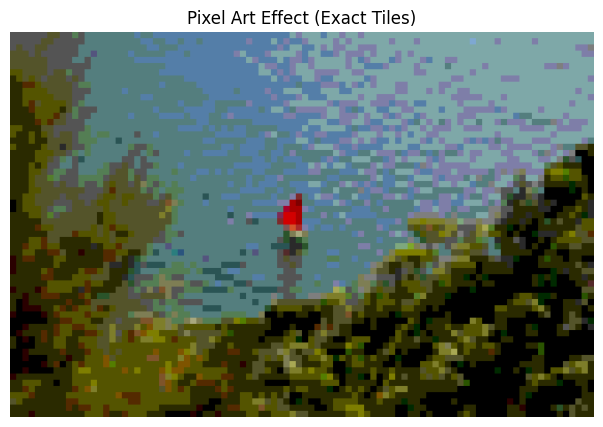

In [ ]:
# 1. Create a "pixel art" effect by setting blocks of pixels to solid colors

def pixel_art_effect(image, block_size=20, levels=6):
    """
    Apply a pixel art effect with reduced vibrant color palette.
    Crops image so dimensions are multiples of block_size.

    Parameters
    ----------
    image : np.ndarray
        Input image (BGR as from cv2.imread).
    block_size : int
        Size of pixel blocks. Larger = chunkier effect.
    levels : int
        Number of color quantization levels (fewer = stronger contrast).

    Returns
    -------
    out : np.ndarray
        Pixelated + quantized image with exact tiling.
    """
    h, w, _ = image.shape

    # Adjust dimensions to nearest multiple of block_size
    h_crop = (h // block_size) * block_size
    w_crop = (w // block_size) * block_size
    image = image[:h_crop, :w_crop]

    out = image.copy()

    # Loop through blocks and quantize colors
    for y in range(0, h_crop, block_size):
        for x in range(0, w_crop, block_size):
            block = image[y:y+block_size, x:x+block_size]
            color = block.mean(axis=(0,1))
            # Quantize to limited palette
            color = (color // (256 // levels)) * (256 // levels)
            out[y:y+block_size, x:x+block_size] = color

    return out

pix_img_01 = pixel_art_effect(img_01, block_size=8, levels=6)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(pix_img_01, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Pixel Art Effect (Exact Tiles)")
plt.show()


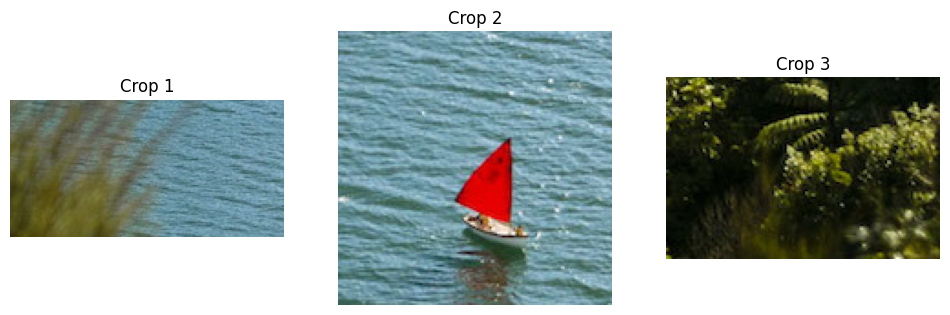

In [ ]:
# 2. Multiple crops in a grid
# Take several regions and show them together.

# Define crops
crop1 = img_01[0:100, 0:200]
crop2 = img_01[150:300, 280:430]
crop3 = img_01[400:500, 600:750]

# Show in a grid
fig, axs = plt.subplots(1, 3, figsize=(12,4))
for ax, crop, title in zip(axs, [crop1, crop2, crop3], ["Crop 1", "Crop 2", "Crop 3"]):
    ax.imshow(crop[:,:,::-1])
    ax.set_title(title)
    ax.axis("off")
plt.show()

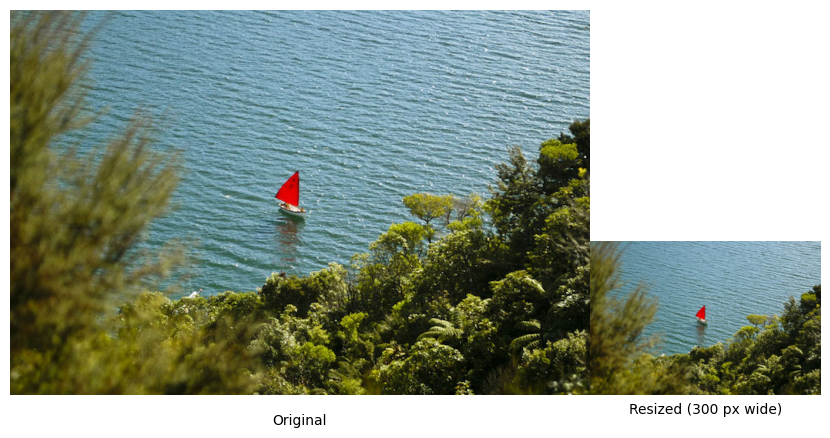

In [ ]:
# 3. Resize while keeping aspect ratio
# Function that rescales to a target width.

def resize_keep_aspect(image, target_width):
    h, w = image.shape[:2]
    scale = target_width / w
    new_size = (target_width, int(h * scale))
    return cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

def show_native_comparison(images, titles=None, dpi=100):
    """
    Show multiple images side-by-side, preserving native pixel scale
    (so smaller images really appear smaller on screen).
    """
    # Compute total width and max height in pixels
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]
    total_width = sum(widths)
    max_height = max(heights)

    # Figure size in inches = pixels / dpi
    fig_w = total_width / dpi
    fig_h = max_height / dpi
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)

    # Place images sequentially in pixel coordinates
    x_offset = 0
    for i, img in enumerate(images):
        h, w = img.shape[:2]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                  extent=[x_offset, x_offset + w, 0, h])
        if titles:
            ax.text(x_offset + w/2, -h*0.05, titles[i],
                    ha="center", va="top", fontsize=10)
        x_offset += w

    ax.set_xlim(0, total_width)
    ax.set_ylim(0, max_height)
    ax.axis("off")
    plt.show()


# Resize
resized_width = 300
resized_img_01 = resize_keep_aspect(img_01, resized_width)

# Show comparison
show_native_comparison(
    [img_01, resized_img_01],
    titles=["Original", f"Resized ({resized_width} px wide)"],
    dpi=100
)


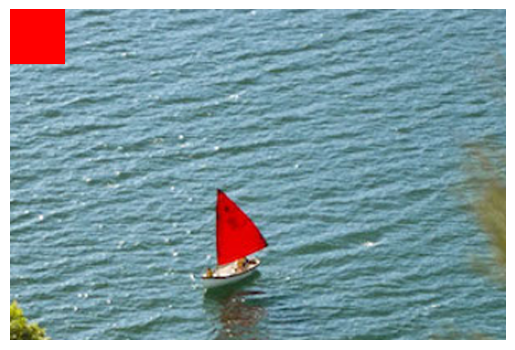

In [ ]:
# Combined transformations
# Crop, resize, flip, modify pixels

# Cropped
combo_cropped_img_01 = img_01[100:300, 200:500]

# Resized
combo_resized_img_01 = cv2.resize(combo_cropped_img_01, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

# Flip
combo_flipped_img_01 = cv2.flip(combo_resized_img_01, 1)

# Modify pixels: draw a red square in top-left
combo_modified_img_01 = combo_flipped_img_01.copy()
combo_modified_img_01[0:50, 0:50] = [0, 0, 255]

plt.imshow(combo_modified_img_01[:,:,::-1])
plt.axis("off")
plt.show()

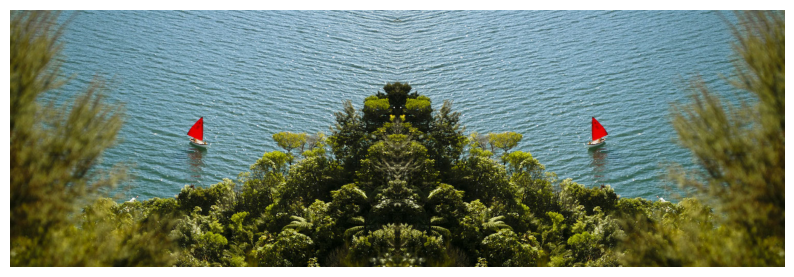

In [ ]:
# 5. Mirrored collage
# Original + flipped side by side.

flipped_img_01 = cv2.flip(img_01, 1)
collage = np.hstack((img_01, flipped_img_01))

plt.figure(figsize=(10,5))
plt.imshow(collage[:,:,::-1])
plt.axis("off")
plt.show()

#Complete Apollo 11 Annotation

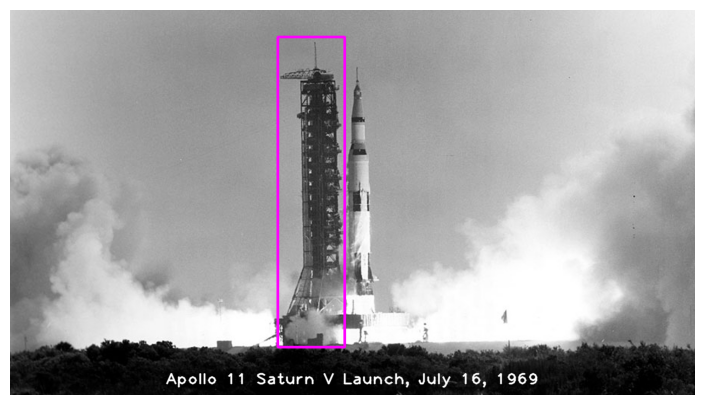

In [ ]:
# Image filename
image_name_02 = "Apollo-11-launch.jpg"

# Construct full URL
image_url_02 = images_base_url + image_name_02

# Use urlopen to get the image data and cv2.imdecode to read it
try:
    resp = urlopen(image_url_02)
    image_array = np.asarray(bytearray(resp.read()), dtype="uint8")
    img_02 = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Check if the image was loaded successfully
    if img_02 is None:
        print(f"Error: Could not load image from {image_url_02}")
    else:
        # Add text
        text = "Apollo 11 Saturn V Launch, July 16, 1969"
        font_face = cv2.FONT_HERSHEY_PLAIN
        font_scale = 2
        thickness = 2
        color_text = (255, 255, 255)

        (text_width, text_height), _ = cv2.getTextSize(text, font_face, font_scale, thickness)
        x_center = (img_02.shape[1] - text_width) // 2
        y_bottom = img_02.shape[0] - 20

        annotated_img_02 = img_02.copy()
        cv2.putText(annotated_img_02, text, (x_center, y_bottom),
                    font_face, font_scale, color_text, thickness, cv2.LINE_AA)

        # Draw rectangle around tower
        rect_start = (500, 50)
        rect_end   = (625, 630)
        rect_color = (255, 0, 255)
        rect_thickness = 3

        cv2.rectangle(annotated_img_02, rect_start, rect_end, rect_color, rect_thickness)

        # Display
        plt.figure(figsize=(10, 5))
        plt.imshow(annotated_img_02[:, :, ::-1])
        plt.axis("off")
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Define additional annotation functions

# 1. Draw arrow (line + arrowhead)
def draw_arrow(img, start, end, color=(0,255,0), thickness=2):
    cv2.arrowedLine(img, start, end, color, thickness, tipLength=0.1)
    return img

# 2. Target pattern (concentric circles)
def draw_target(img, center, radii, color=(0,0,255), thickness=2):
    for r in radii:
        cv2.circle(img, center, r, color, thickness)
    return img

# 3. Grid overlay
def draw_grid(img, spacing=50, color=(255,255,0), thickness=1):
    h, w = img.shape[:2]
    for x in range(0, w, spacing):
        cv2.line(img, (x,0), (x,h), color, thickness)
    for y in range(0, h, spacing):
        cv2.line(img, (0,y), (w,y), color, thickness)
    return img

# 4. Timestamp (bottom-right corner)
def add_timestamp(img, fmt="%Y-%m-%d %H:%M:%S", color=(255,255,255)):
    ts = datetime.now().strftime(fmt)
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale, thick = 0.7, 2
    (tw, th), _ = cv2.getTextSize(ts, font, scale, thick)
    x = img.shape[1] - tw - 10
    y = img.shape[0] - 10
    cv2.putText(img, ts, (x, y), font, scale, color, thick, cv2.LINE_AA)
    return img

# 5. Path (connect points)
def draw_path(img, points, color=(0,255,255), thickness=2):
    for i in range(len(points)-1):
        cv2.line(img, points[i], points[i+1], color, thickness)
    return img

# 6. Filled rectangle with transparency
def draw_transparent_rect(img, start, end, color=(0,0,255), alpha=0.3):
    overlay = img.copy()
    cv2.rectangle(overlay, start, end, color, -1)  # filled rect
    cv2.addWeighted(overlay, alpha, img, 1-alpha, 0, img)
    return img

# 7. Face annotation (rectangle + circles for eyes)
def annotate_face(img, face_rect, eye_centers, eye_radius=20):
    x1,y1,x2,y2 = face_rect
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    for (ex,ey) in eye_centers:
        cv2.circle(img, (ex,ey), eye_radius, (255,0,0), 2)
    return img

# 7. Face annotation (rectangle + circles for eyes)
def annotate_face(
    img,
    face_rect,
    eye_centers,
    eye_radius=20,
    face_color=(0,255,0),   # default green
    eye_color=(255,0,0),    # default blue
    thickness=2
):
    x1, y1, x2, y2 = face_rect
    cv2.rectangle(img, (x1,y1), (x2,y2), face_color, thickness)
    for (ex, ey) in eye_centers:
        cv2.circle(img, (ex,ey), eye_radius, eye_color, thickness)
    return img

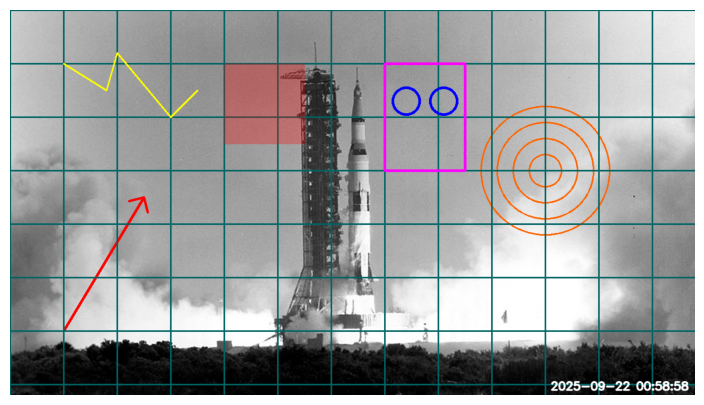

In [ ]:
# Apply additional annotations
elements_img_02 = img_02.copy()

elements_img_02 = draw_arrow(elements_img_02, (100,600), (250,350), color=(0,0,255), thickness=3)
elements_img_02 = draw_target(elements_img_02, (1000,300), [30,60,90,120], color=(0,100,255), thickness=2)
elements_img_02 = draw_grid(elements_img_02, spacing=100, color=(100,100,0), thickness=2)
elements_img_02 = add_timestamp(elements_img_02)
elements_img_02 = draw_path(elements_img_02, [(100,100),(180,150),(200,80),(300,200),(350,150)])
elements_img_02 = draw_transparent_rect(elements_img_02, (400,100),(550,250))
elements_img_02 = annotate_face(elements_img_02, (700,100,850,300), [(740,170),(810,170)],
                         eye_radius=25, face_color=(255,0,255), eye_color=(255,0,0), thickness=3)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(elements_img_02, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


#Image processing

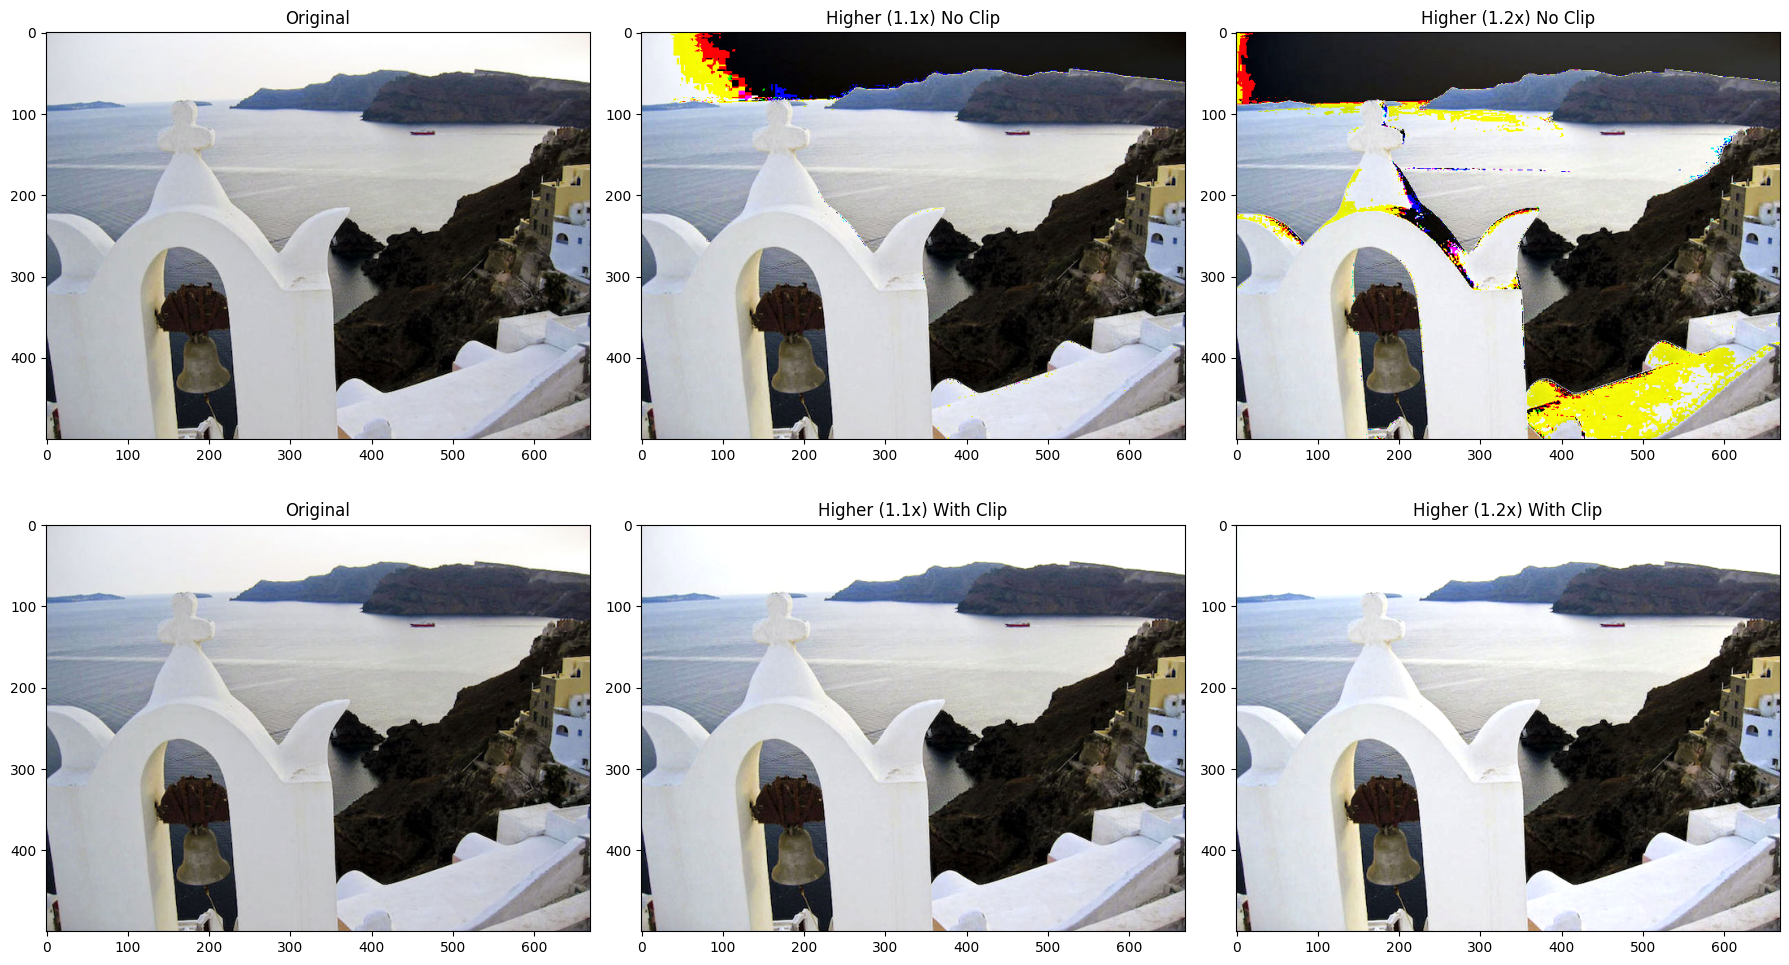

In [ ]:
# Image filename
image_name_03 = "Santorini.jpg"

# Construct full URL
image_url_03 = images_base_url + image_name_03

# Use urlopen to get the image data and cv2.imdecode to read it
try:
    resp = urlopen(image_url_03)
    image_array_03 = np.asarray(bytearray(resp.read()), dtype="uint8")
    img_03 = cv2.imdecode(image_array_03, cv2.IMREAD_COLOR)

    # Check if image loaded successfully
    if img_03 is None:
        print(f"Error: Could not load image from {image_url_03}")
    else:
        # Matrix of ones
        matrix_ones_03 = np.ones_like(img_03, dtype=np.float64)

        # Higher contrast WITHOUT overflow handling
        img_03_higher1 = (img_03.astype(np.float64) * 1.1 * matrix_ones_03).astype(np.uint8)
        img_03_higher2 = (img_03.astype(np.float64) * 1.2 * matrix_ones_03).astype(np.uint8)

        # Display first row (with artifacts)
        plt.figure(figsize=(18, 10))
        plt.subplot(231); plt.imshow(img_03[:, :, ::-1]); plt.title('Original')
        plt.subplot(232); plt.imshow(img_03_higher1[:, :, ::-1]); plt.title('Higher (1.1x) No Clip')
        plt.subplot(233); plt.imshow(img_03_higher2[:, :, ::-1]); plt.title('Higher (1.2x) No Clip')

        # Higher contrast WITH overflow handling
        img_03_higher1_clip = np.clip(img_03.astype(np.float64) * 1.1, 0, 255).astype(np.uint8)
        img_03_higher2_clip = np.clip(img_03.astype(np.float64) * 1.2, 0, 255).astype(np.uint8)

        # Display second row (clipped, fixed)
        plt.subplot(234); plt.imshow(img_03[:, :, ::-1]); plt.title('Original')
        plt.subplot(235); plt.imshow(img_03_higher1_clip[:, :, ::-1]); plt.title('Higher (1.1x) With Clip')
        plt.subplot(236); plt.imshow(img_03_higher2_clip[:, :, ::-1]); plt.title('Higher (1.2x) With Clip')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# Define additional adaptive image processing functions

# 1. Auto brightness adjustment based on histogram
def auto_brightness(img, target_mean=128):
    """
    Shift brightness so image mean intensity ≈ target_mean.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    current_mean = gray.mean()
    ratio = target_mean / (current_mean + 1e-5)
    adjusted = np.clip(img.astype(np.float32) * ratio, 0, 255).astype(np.uint8)
    return adjusted

# 2. Adaptive contrast adjustment (CLAHE for local regions)
def adaptive_contrast(img, clip_limit=2.0, tile_size=(8,8)):
    """
    Apply adaptive histogram equalization (CLAHE) on L-channel in LAB space.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

# 3. Combined brightness + contrast
def adjust_brightness_contrast(img, brightness=0, contrast=1.0):
    """
    brightness: value added to all pixels
    contrast: multiplier applied after brightness
    """
    adjusted = np.clip((img.astype(np.float32) + brightness) * contrast, 0, 255).astype(np.uint8)
    return adjusted

# 4. HDR-like effect by channel-specific contrast
def hdr_like(img, factors=(1.2, 1.1, 1.3)):
    """
    Apply different contrast scaling to B, G, R channels.
    """
    channels = cv2.split(img.astype(np.float32))
    out_channels = [np.clip(c * f, 0, 255) for c, f in zip(channels, factors)]
    return cv2.merge([c.astype(np.uint8) for c in out_channels])

# 6. Non-uniform brightness (gradient mask)
def gradient_brightness(img, axis=0):
    """
    Apply a linear brightness gradient across rows (axis=0) or columns (axis=1).
    """
    h, w = img.shape[:2]
    if axis == 0:
        gradient = np.linspace(0.5, 1.5, h).reshape(h,1,1)
        mask = np.tile(gradient, (1,w,3))
    else:
        gradient = np.linspace(0.5, 1.5, w).reshape(1,w,1)
        mask = np.tile(gradient, (h,1,3))
    adjusted = np.clip(img.astype(np.float32) * mask, 0, 255).astype(np.uint8)
    return adjusted


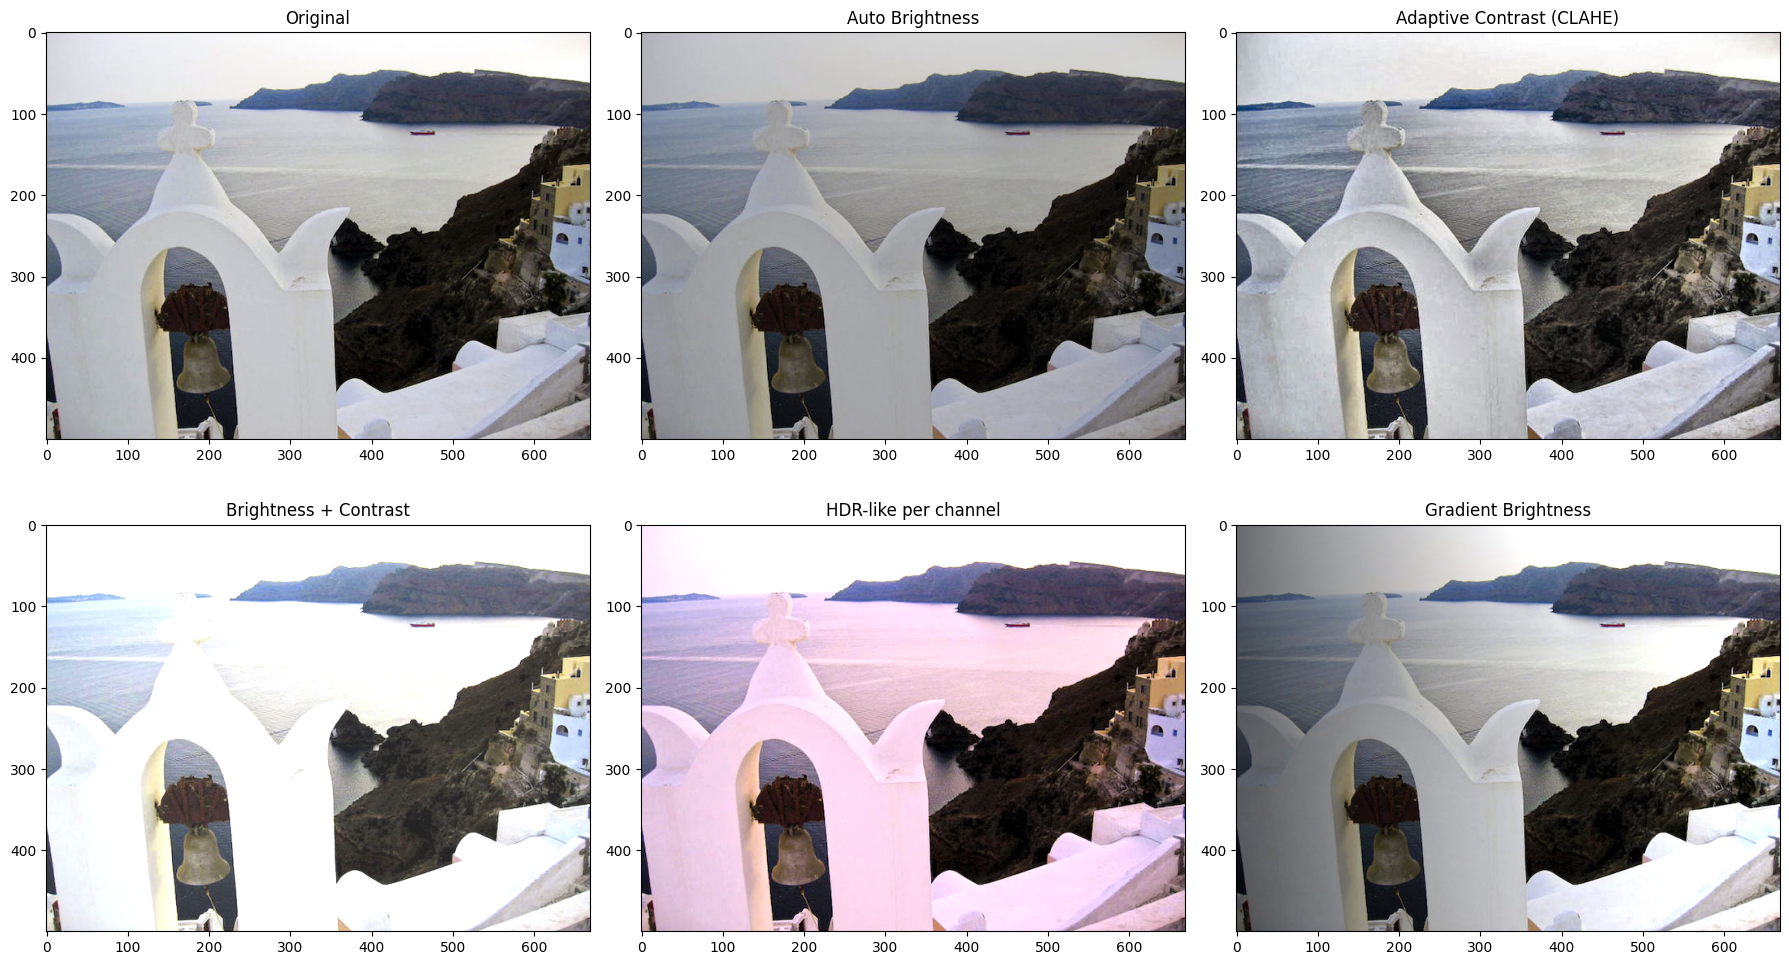

In [ ]:
# Apply adaptive image processing
auto = auto_brightness(img_03)
clahe = adaptive_contrast(img_03)
combined = adjust_brightness_contrast(img_03, brightness=30, contrast=1.2)
hdr = hdr_like(img_03)
grad = gradient_brightness(img_03, axis=1)

plt.figure(figsize=(18,10))
plt.subplot(231); plt.imshow(img_03[:,:,::-1]); plt.title("Original")
plt.subplot(232); plt.imshow(auto[:,:,::-1]); plt.title("Auto Brightness")
plt.subplot(233); plt.imshow(clahe[:,:,::-1]); plt.title("Adaptive Contrast (CLAHE)")
plt.subplot(234); plt.imshow(combined[:,:,::-1]); plt.title("Brightness + Contrast")
plt.subplot(235); plt.imshow(hdr[:,:,::-1]); plt.title("HDR-like per channel")
plt.subplot(236); plt.imshow(grad[:,:,::-1]); plt.title("Gradient Brightness")
plt.tight_layout()
plt.show()


In [50]:
# Define interactive image processing functions

def adjust_brightness_contrast(img, brightness=0, contrast=1.0):
    """
    Adjust brightness and contrast of an image.

    Parameters
    ----------
    img : np.ndarray
        Input image in BGR format.
    brightness : int
        Value to add to each pixel (-100 to +100).
    contrast : float
        Multiplier applied after brightness (0.1 to 3.0).

    Returns
    -------
    np.ndarray
        Adjusted image in BGR format.
    """
    adjusted = np.clip((img.astype(np.float32) + brightness) * contrast, 0, 255)
    return adjusted.astype(np.uint8)

def interactive_adjust_ipywidgets(img):
    """
    Create interactive brightness/contrast sliders in Jupyter/Colab.

    Opens two sliders (brightness, contrast) and updates the displayed
    image in real time when values are changed.

    Parameters
    ----------
    img : np.ndarray
        Input image in BGR format.
    """
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Define sliders
    brightness_slider = widgets.IntSlider(value=0, min=-100, max=100, step=1, description='Brightness')
    contrast_slider = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Contrast')

    # Update function
    def update(brightness, contrast):
        adj = adjust_brightness_contrast(img_rgb, brightness, contrast)
        plt.figure(figsize=(10,5))
        plt.imshow(adj)
        plt.axis("off")
        plt.show()

    # Link sliders to update function
    ui = widgets.VBox([contrast_slider, brightness_slider])
    out = widgets.interactive_output(update, {"brightness": brightness_slider, "contrast": contrast_slider})

    display(ui, out)

In [52]:
# Adjust contrast and brightness using interactive sliders
interactive_adjust_ipywidgets(img_03)

Output()